In [17]:
# data_explore_gt_viz.py
# Dataset counts + visualize one GT file: show original image, annotations, density (jet), overlay.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [18]:
plt.rcParams["figure.figsize"] = (8,6)

In [19]:
# ========== EDIT THESE ==========
DATASET_PATH = r"C:\Users\mahal\OneDrive\Desktop\DL\archive\ShanghaiTech"
CHOOSE_PART = "part_A"   # "part_A" or "part_B"
SPLIT = "train_data"     # "train_data" or "test_data"
INDEX = 3               # which image/GT to use (0-based)
# ==============================

In [20]:
def show(img, title=None, cmap=None):
    plt.figure()
    if img is None:
        return
    if img.ndim == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap if cmap else "viridis")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

In [21]:
# ---------------- dataset exploration (your original code) ----------------
print("📌 Dataset Exploration\n")

📌 Dataset Exploration



In [22]:
# Part A
part_a_train_img = os.listdir(os.path.join(DATASET_PATH, "part_A", "train_data", "images"))
part_a_train_gt  = os.listdir(os.path.join(DATASET_PATH, "part_A", "train_data", "ground-truth"))

In [23]:
part_a_test_img = os.listdir(os.path.join(DATASET_PATH, "part_A", "test_data", "images"))
part_a_test_gt  = os.listdir(os.path.join(DATASET_PATH, "part_A", "test_data", "ground-truth"))

In [24]:
print("🔶 Part A")
print("Training images:", len(part_a_train_img))
print("Training ground-truth files:", len(part_a_train_gt))
print("Testing images:", len(part_a_test_img))
print("Testing ground-truth files:", len(part_a_test_gt), "\n")

🔶 Part A
Training images: 300
Training ground-truth files: 300
Testing images: 181
Testing ground-truth files: 182 



In [25]:
# Part B
part_b_train_img = os.listdir(os.path.join(DATASET_PATH, "part_B", "train_data", "images"))
part_b_train_gt  = os.listdir(os.path.join(DATASET_PATH, "part_B", "train_data", "ground-truth"))

In [26]:
part_b_test_img = os.listdir(os.path.join(DATASET_PATH, "part_B", "test_data", "images"))
part_b_test_gt  = os.listdir(os.path.join(DATASET_PATH, "part_B", "test_data", "ground-truth"))

In [27]:
print("🔷 Part B")
print("Training images:", len(part_b_train_img))
print("Training ground-truth files:", len(part_b_train_gt))
print("Testing images:", len(part_b_test_img))
print("Testing ground-truth files:", len(part_b_test_gt))
print("\n---\n")

🔷 Part B
Training images: 400
Training ground-truth files: 400
Testing images: 316
Testing ground-truth files: 316

---



In [28]:
# ---------------- pick one sample image + matching gt (no preprocessing) --------------
images_dir = os.path.join(DATASET_PATH, CHOOSE_PART, SPLIT, "images")
gt_dir     = os.path.join(DATASET_PATH, CHOOSE_PART, SPLIT, "ground-truth")

In [29]:
img_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))])
gt_files  = sorted([f for f in os.listdir(gt_dir) if f.lower().endswith('.mat')])

In [30]:
if not img_files:
    raise RuntimeError("No images found in " + images_dir)

In [31]:
# choose image by INDEX
img_name = img_files[min(INDEX, len(img_files)-1)]
img_path = os.path.join(images_dir, img_name)

In [32]:
# try to find matching GT file by ShanghaiTech naming convention
base = os.path.splitext(img_name)[0]
candidate_gt = "GT_" + base + ".mat"
gt_path = os.path.join(gt_dir, candidate_gt)
if not os.path.exists(gt_path):
    # fallback: try same index in sorted list
    gt_path = os.path.join(gt_dir, gt_files[min(INDEX, len(gt_files)-1)]) if gt_files else None

In [33]:
print("Sample image:", img_path)
print("Matched GT (used):", gt_path)
print()

Sample image: C:\Users\mahal\OneDrive\Desktop\DL\archive\ShanghaiTech\part_A\train_data\images\IMG_101.jpg
Matched GT (used): C:\Users\mahal\OneDrive\Desktop\DL\archive\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_101.mat



In [34]:
# ---------------- robust loader for ShanghaiTech .mat ----------------
def load_points_from_mat(path):
    data = sio.loadmat(path)
    # 1) ShanghaiTech nesting: image_info[0][0][0][0][0]
    try:
        if 'image_info' in data:
            cand = data['image_info'][0][0][0][0][0]
            pts = np.array(cand).squeeze()
            return pts.reshape(-1,2).astype(np.float32)
    except Exception:
        pass
    # 2) other nests inside image_info
    try:
        if 'image_info' in data:
            info = data['image_info'][0][0]
            if hasattr(info, 'dtype') and info.dtype.names:
                for key in ('location','annPoints','points','gt','GT'):
                    if key in info.dtype.names:
                        val = info[key]
                        arr = np.array(val).squeeze()
                        return arr.reshape(-1,2).astype(np.float32)
    except Exception:
        pass
    # 3) top-level Nx2 fallback
    for v in data.values():
        if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] == 2:
            return v.astype(np.float32)
    # 4) last resort, flattenable
    for v in data.values():
        if isinstance(v, np.ndarray):
            flat = v.flatten()
            if flat.size >= 2 and flat.size % 2 == 0:
                try:
                    return flat.reshape(-1,2).astype(np.float32)
                except Exception:
                    pass
    raise ValueError("No Nx2 points found in MAT. Keys: " + ",".join(data.keys()))

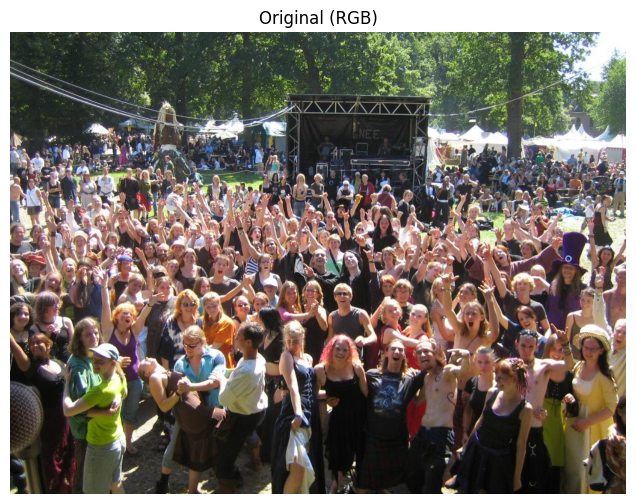

In [35]:
# ---------------- read image (original size) and display ----------------
bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if bgr is None:
    raise RuntimeError("Failed to read image: " + img_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
show(rgb, "Original (RGB)")

Loaded annotation points: 298


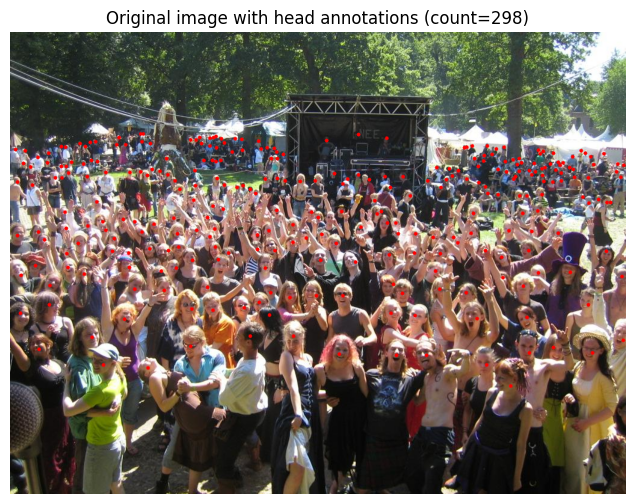

In [36]:
# ---------------- load GT and overlay head annotations (original coords) ----------------
points = None
if gt_path and os.path.exists(gt_path):
    try:
        pts = load_points_from_mat(gt_path)
        print("Loaded annotation points:", len(pts))
        # pts are expected in original image coordinates (x,y). We'll overlay directly.
        pts_orig = pts.copy().astype(np.float32)
        overlay = rgb.copy()
        for (x,y) in pts_orig:
            cx, cy = int(round(x)), int(round(y))
            if 0 <= cx < overlay.shape[1] and 0 <= cy < overlay.shape[0]:
                cv2.circle(overlay, (cx, cy), 3, (255,0,0), -1)  # red dot in RGB
        show(overlay, f"Original image with head annotations (count={len(pts_orig)})")
        points = pts_orig
    except Exception as e:
        print("Failed to load GT:", e)
else:
    print("GT file not found or not set; skipping annotations.")

In [37]:
# ---------------- density map on original image size (jet colormap, blue background) ----------------
def generate_density_map(shape_hw, points_xy, sigma=15.0):
    H, W = shape_hw
    density = np.zeros((H, W), dtype=np.float32)
    for (x,y) in points_xy:
        ix = int(round(x)); iy = int(round(y))
        if 0 <= ix < W and 0 <= iy < H:
            density[iy, ix] += 1.0
    k = max(3, int(6*sigma) | 1)
    density = cv2.GaussianBlur(density, (k,k), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REPLICATE)
    return density

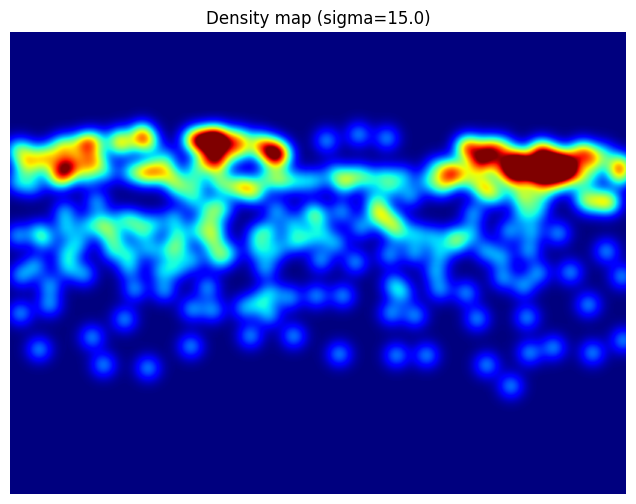

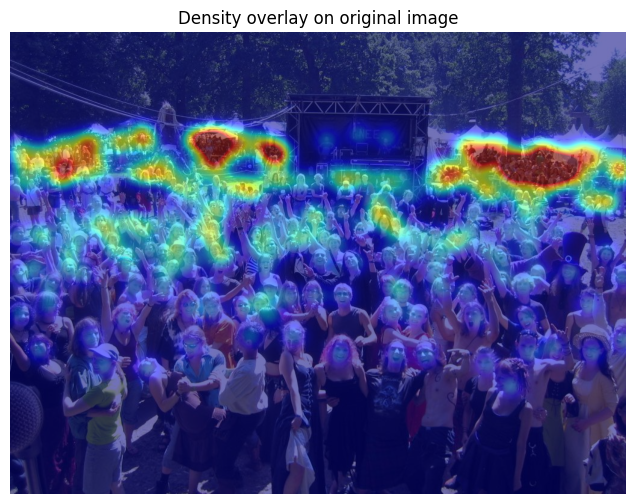

In [38]:
if points is not None:
    H, W = rgb.shape[:2]
    sigma = 15.0
    density = generate_density_map((H, W), points, sigma=sigma)
    vmax = np.percentile(density, 99)
    if vmax <= 0:
        vmax = density.max() if density.max() > 0 else 1.0

    # show density (jet) with blue background like reference
    plt.figure()
    plt.imshow(density, cmap='jet', vmin=0, vmax=vmax, interpolation='bilinear', origin='upper')
    plt.title(f"Density map (sigma={sigma})")
    plt.axis('off')
    plt.show()

    # overlay density onto original image
    norm = (density - density.min()) / (vmax - density.min() + 1e-9)
    colored = plt.cm.jet(norm)[:,:,:3]  # RGB 0..1
    alpha = 0.55
    base_rgb = rgb.astype(np.float32) / 255.0
    overlay_img = (1 - alpha) * base_rgb + alpha * colored
    overlay_img = np.clip(overlay_img, 0.0, 1.0)
    show(overlay_img, "Density overlay on original image")
else:
    print("No annotations -> density map skipped.")